In [1]:
pip install numpy yfinance scipy tqdm python-bcb google-generativeai scikit-learn jinja2 matplotlib plotly nbformat

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import os
import numpy as np
import pandas as pd
import yfinance as yf
import scipy.optimize as scpopt
from tqdm import tqdm
from bcb import sgs
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import google.generativeai as genai
from datetime import datetime
import matplotlib.pyplot as plt
#from openai import OpenAI
import plotly

/home/caio/Documentos/ic24_repo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#pip install google.generativeai

In [4]:
#pip install plotly

Períodos do modelo

In [5]:
data_inicio = '2012-01-01'
data_fim = '2025-07-01'
data_backtest = "2022-07-01" 

TradingView

In [6]:
pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git

  Cloning https://github.com/rongardF/tvdatafeed.git to /tmp/pip-req-build-09k16lgw
  Running command git clone --filter=blob:none --quiet https://github.com/rongardF/tvdatafeed.git /tmp/pip-req-build-09k16lgw
  Resolved https://github.com/rongardF/tvdatafeed.git to commit e6f6aaa7de439ac6e454d9b26d2760ded8dc4923
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [7]:
import os

from tvDatafeed import TvDatafeed, Interval

user = os.getenv("TV_USER")
pas = os.getenv("TV_PASS")

tv = TvDatafeed(username= "user", password = "pas")

error while signin
you are using nologin method, data you access may be limited


Obtenção das variáveis macroeconômicas

In [8]:
codigos_sgs = {
    'SELIC': 4189, # Usando a SELIC mensalizada diretamente
    'IPCA': 433,
    'IBC-Br': 24369,
    'DESEMPREGO': 24369,
    'Investimento Direto no País': 22886,
}

dados_bcb = pd.DataFrame()

# Buscar e juntar cada série
for nome_serie, codigo in codigos_sgs.items():
    try:
        print(f"Buscando: {nome_serie} (código {codigo})...")
        serie = sgs.get({nome_serie: codigo}, start= data_inicio, end= data_fim)

        # Se o DataFrame principal ainda estiver vazio, ele se torna a primeira série
        if dados_bcb.empty:
            dados_bcb = serie
        # Caso contrário, juntamos (join) a nova série ao DataFrame existente
        else:
            dados_bcb = dados_bcb.join(serie)

    except Exception as e:
        print(f"AVISO: Falha ao buscar a série '{nome_serie}' (código {codigo}). Erro: {e}. Pulando...")

# 3. Verificação final
if not dados_bcb.empty:
    print("\nDados do BCB e IBGE obtidos com sucesso (método join):")
    display(dados_bcb.tail())
else:
    print("\nNenhuma série do Banco Central pôde ser baixada.")

# Lista de dados de mercado
tickers_mercado = {
    'VIX': '^VIX',
    'PETROLEO_BRENT': 'BZ=F',
    'DOW_JONES': '^DJI',
    'COMM_AGRICOLA': 'DBA', # Usando o ETF 'DBA'
    'CAMBIO_USDBRL': 'USDBRL=X'
}

print("\nBuscando dados de índices de mercado e commodities...")
# Mesma lógica de baixar dado diário para mensal
dados_mercado_diario_raw = yf.download(
    list(tickers_mercado.values()),
    start= data_inicio, end= data_fim,
    auto_adjust=True
)['Close']

mapa_renomear = {v: k for k, v in tickers_mercado.items()}

# Usamos o método .rename() que é explícito e não depende da ordem
dados_mercado_diario = dados_mercado_diario_raw.rename(columns=mapa_renomear)

# Reordenar as colunas para a ordem certa
dados_mercado_diario = dados_mercado_diario[list(tickers_mercado.keys())]

print("\nDados de Mercado (diários) - Corrigidos e Verificados:")
display(dados_mercado_diario.tail())

# 1. Converter dados de mercado para o final do mês
dados_mercado_mensal = dados_mercado_diario.resample('ME').last()

print("Índice original do 'dados_bcb':")
display(dados_bcb.head(2))

dados_bcb.index = dados_bcb.index.to_period('M').to_timestamp('M')

print("\nÍndice padronizado do 'dados_bcb' (agora com fim de mês):")
display(dados_bcb.head(2))


#Juntando os dados
dados_macro_combinados = dados_bcb.join(dados_mercado_mensal)


# O ffill() ainda é útil para cobrir feriados ou dias em que um dos mercados não abriu.
# O dropna() remove qualquer linha no início que possa ter ficado sem dados completos.
dados_macro_combinados = dados_macro_combinados.ffill().dropna()

dados_macro_combinados.index = dados_macro_combinados.index.to_period('M').to_timestamp('M')
dados_macro_combinados.index = pd.to_datetime(dados_macro_combinados.index)

print("\n--- DataFrame Final com Todos os Indicadores Macroeconômicos ---")
display(dados_macro_combinados.tail())
display(dados_macro_combinados.head())

Buscando: SELIC (código 4189)...
Buscando: IPCA (código 433)...
Buscando: IBC-Br (código 24369)...
Buscando: DESEMPREGO (código 24369)...
Buscando: Investimento Direto no País (código 22886)...

Dados do BCB e IBGE obtidos com sucesso (método join):


,SELIC,IPCA,IBC-Br,DESEMPREGO,Investimento Direto no País
Date,,,,,
2025-03-01,13.57,0.56,7.0,7.0,11636.7
2025-04-01,14.15,0.43,6.6,6.6,14363.2
2025-05-01,14.55,0.26,6.2,6.2,11546.8
2025-06-01,14.74,0.24,5.8,5.8,12960.0
2025-07-01,14.90,0.26,5.6,5.6,17633.8



Buscando dados de índices de mercado e commodities...


[*********************100%***********************]  5 of 5 completed


Dados de Mercado (diários) - Corrigidos e Verificados:


Ticker,VIX,PETROLEO_BRENT,DOW_JONES,COMM_AGRICOLA,CAMBIO_USDBRL
Date,,,,,
2025-06-24,17.48,67.139999,43089.019531,26.290001,5.4938
2025-06-25,16.76,67.680000,42982.429688,26.080000,5.5103
2025-06-26,16.59,67.730003,43386.839844,26.139999,5.5579
2025-06-27,16.32,67.769997,43819.269531,26.330000,5.4771
2025-06-30,16.73,67.610001,44094.769531,26.150000,5.4784


Índice original do 'dados_bcb':


,SELIC,IPCA,IBC-Br,DESEMPREGO,Investimento Direto no País
Date,,,,,
2012-01-01,10.7,0.56,NaN,NaN,10670.8
2012-02-01,10.4,0.45,NaN,NaN,6216.9



Índice padronizado do 'dados_bcb' (agora com fim de mês):


,SELIC,IPCA,IBC-Br,DESEMPREGO,Investimento Direto no País
Date,,,,,
2012-01-31,10.7,0.56,NaN,NaN,10670.8
2012-02-29,10.4,0.45,NaN,NaN,6216.9



--- DataFrame Final com Todos os Indicadores Macroeconômicos ---


,SELIC,IPCA,IBC-Br,DESEMPREGO,Investimento Direto no País,VIX,PETROLEO_BRENT,DOW_JONES,COMM_AGRICOLA,CAMBIO_USDBRL
Date,,,,,,,,,,
2025-03-31,13.57,0.56,7.0,7.0,11636.7,22.280001,74.739998,42001.761719,26.340000,5.7581
2025-04-30,14.15,0.43,6.6,6.6,14363.2,24.700001,63.119999,40669.359375,26.809999,5.6200
2025-05-31,14.55,0.26,6.2,6.2,11546.8,18.570000,63.900002,42270.070312,26.700001,5.6651
2025-06-30,14.74,0.24,5.8,5.8,12960.0,16.730000,67.610001,44094.769531,26.150000,5.4784
2025-07-31,14.90,0.26,5.6,5.6,17633.8,16.730000,67.610001,44094.769531,26.150000,5.4784


,SELIC,IPCA,IBC-Br,DESEMPREGO,Investimento Direto no País,VIX,PETROLEO_BRENT,DOW_JONES,COMM_AGRICOLA,CAMBIO_USDBRL
Date,,,,,,,,,,
2012-03-31,9.82,0.21,8.0,8.0,16549.8,15.500000,122.879997,13212.040039,25.025694,1.8208
2012-04-30,9.35,0.64,7.8,7.8,6664.0,17.150000,119.470001,13213.629883,24.304312,1.8860
2012-05-31,8.87,0.36,7.7,7.7,6263.8,24.059999,101.870003,12393.450195,23.226692,2.0149
2012-06-30,8.39,0.08,7.6,7.6,9004.9,17.080000,97.800003,12880.089844,25.132563,2.0768
2012-07-31,8.07,0.43,7.5,7.5,10912.8,18.930000,104.919998,13008.679688,26.833597,2.0403


In [9]:
# Criando um novo DataFrame para as features aprimoradas
dados_macro_features = pd.DataFrame(index=dados_macro_combinados.index)

# Calculando a variação mensal (a diferença) para cada indicador
for coluna in dados_macro_combinados.columns:
    dados_macro_features[f'{coluna}_diff'] = dados_macro_combinados[coluna].pct_change()

# Removendo a primeira linha que terá valores NaN (vazios)
dados_macro_features = dados_macro_features.dropna()

print("Comparando os dados originais com as novas features (variações):")
display(dados_macro_combinados.head(3))
display(dados_macro_combinados.tail(3))
display(dados_macro_features.tail(3))

dados_macro_combinados = dados_macro_features

Comparando os dados originais com as novas features (variações):


,SELIC,IPCA,IBC-Br,DESEMPREGO,Investimento Direto no País,VIX,PETROLEO_BRENT,DOW_JONES,COMM_AGRICOLA,CAMBIO_USDBRL
Date,,,,,,,,,,
2012-03-31,9.82,0.21,8.0,8.0,16549.8,15.500000,122.879997,13212.040039,25.025694,1.8208
2012-04-30,9.35,0.64,7.8,7.8,6664.0,17.150000,119.470001,13213.629883,24.304312,1.8860
2012-05-31,8.87,0.36,7.7,7.7,6263.8,24.059999,101.870003,12393.450195,23.226692,2.0149


,SELIC,IPCA,IBC-Br,DESEMPREGO,Investimento Direto no País,VIX,PETROLEO_BRENT,DOW_JONES,COMM_AGRICOLA,CAMBIO_USDBRL
Date,,,,,,,,,,
2025-05-31,14.55,0.26,6.2,6.2,11546.8,18.57,63.900002,42270.070312,26.700001,5.6651
2025-06-30,14.74,0.24,5.8,5.8,12960.0,16.73,67.610001,44094.769531,26.150000,5.4784
2025-07-31,14.90,0.26,5.6,5.6,17633.8,16.73,67.610001,44094.769531,26.150000,5.4784


,SELIC_diff,IPCA_diff,IBC-Br_diff,DESEMPREGO_diff,Investimento Direto no País_diff,VIX_diff,PETROLEO_BRENT_diff,DOW_JONES_diff,COMM_AGRICOLA_diff,CAMBIO_USDBRL_diff
Date,,,,,,,,,,
2025-05-31,0.028269,-0.395349,-0.060606,-0.060606,-0.196084,-0.248178,0.012357,0.039359,-0.004103,0.008025
2025-06-30,0.013058,-0.076923,-0.064516,-0.064516,0.122389,-0.099085,0.058059,0.043168,-0.020599,-0.032956
2025-07-31,0.010855,0.083333,-0.034483,-0.034483,0.360633,0.000000,0.000000,0.000000,0.000000,0.000000


In [10]:
ativos = ['VALE3.SA', 'PETR4.SA', 'ITUB4.SA', 'BRFS3.SA', 'ABEV3.SA', 'WEGE3.SA',
            'EGIE3.SA', 'LREN3.SA', 'BBAS3.SA', 'SLCE3.SA' ] 

n_ativos   = len(ativos)
carteira = sorted(ativos)

In [12]:
# 1. Baixar dados base (Ibovespa e Selic)
ibov_dados = tv.get_hist(
    symbol='IBOV',
    exchange='BMFBOVESPA',
    interval=Interval.in_monthly,  # equivalente ao "1mo" do yfinance
    n_bars=500                     # número máximo de candles (ajuste conforme necessário)
)

# mantém só o fechamento
ibov_dados = ibov_dados['close']
ibov_retornos_brutos = np.log(ibov_dados / ibov_dados.shift(1)).dropna()

selic_mensal = sgs.get({'Selic': 4390}, start=data_inicio, end=data_fim)
#selic_mensal = (selic_anual_pct / 100) / 12

selic_mensal = selic_mensal / 100
selic_mensal.rename(columns={'Selic': 'Taxa_Livre_Risco'}, inplace=True)
print(selic_mensal)

# 2. Padronizar índices para garantir alinhamento
ibov_retornos_brutos.index = pd.to_datetime(ibov_retornos_brutos.index).to_period('M').to_timestamp('M')
selic_mensal.index = pd.to_datetime(selic_mensal.index).to_period('M').to_timestamp('M')

# 3. --- CORREÇÃO --- Calcular as métricas a partir dos RETORNOS EXCEDENTES

# Para o Ibovespa
ibov_retornos_excedentes = ibov_retornos_brutos.subtract(selic_mensal['Taxa_Livre_Risco'], axis=0).dropna()
# ibov_retorno_excedente_medio = ibov_retornos_excedentes.mean()
# ibov_volatilidade = ibov_retornos_excedentes.std() # Volatilidade do prêmio de risco
# ibov_sharpe_correto = ibov_retorno_excedente_medio / ibov_volatilidade

print(ibov_retornos_excedentes)

            Taxa_Livre_Risco
Date                        
2012-01-01            0.0089
2012-02-01            0.0075
2012-03-01            0.0082
2012-04-01            0.0071
2012-05-01            0.0074
...                      ...
2025-03-01            0.0096
2025-04-01            0.0106
2025-05-01            0.0114
2025-06-01            0.0110
2025-07-01            0.0128

[163 rows x 1 columns]
2012-01-31    0.096654
2012-02-29    0.035016
2012-03-31   -0.028163
2012-04-30   -0.049704
2012-05-31   -0.133606
                ...   
2025-03-31    0.049379
2025-04-30    0.025642
2025-05-31    0.003004
2025-06-30    0.002252
2025-07-31   -0.055344
Freq: ME, Length: 163, dtype: float64


In [13]:
def retornos_mensais(data_inicio, data_fim):

    # Baixar dados diários com ajuste de dividendos
    dados = yf.download( ativos, start= data_inicio, end=data_fim, interval="1mo", auto_adjust=True)["Close"]
    #dadosF = yf.download( ativos, start="2019-06-01", end="2024-06-01", interval="1mo", auto_adjust=False)["Close"]


    dados.columns = [ticker.replace('.SA', '') for ticker in dados.columns]
    #dadosF.columns = [ticker.replace('.SA', '') for ticker in dados.columns]


    # Remover colunas totalmente vazias
    dados = dados.dropna(axis=1, how='all')
    #dadosF = dados.dropna(axis=1, how='all')

    # Calcular retorno logarítmico mensal
    retornos_absolutos = np.log(dados / dados.shift(1)).dropna()
    #retornos_mensaisF = np.log(dadosF / dadosF.shift(1)).dropna()


    # Usamos o código 4189 do SGS, que é a Selic mensalizada
    selic_anual_pct = sgs.get({'Selic': 4189}, start=data_inicio, end=data_fim)

    # Converte a taxa de % anual para decimal mensal
    selic_mensal = (selic_anual_pct / 100) / 12
    print(selic_mensal)
    selic_mensal.rename(columns={'Selic': 'Taxa_Livre_Risco'}, inplace=True)
    print("Selic baixada e convertida para taxa mensal.")


    # --- PASSO 3: GARANTIR O ALINHAMENTO DAS DATAS ---
    # Padroniza ambos os índices para o fim do mês para garantir a subtração correta
    retornos_absolutos.index = pd.to_datetime(retornos_absolutos.index).to_period('M').to_timestamp('M')
    selic_mensal.index = pd.to_datetime(selic_mensal.index).to_period('M').to_timestamp('M')


    # --- PASSO 4: CALCULAR OS RETORNOS EXCEDENTES ---
    print("Calculando os retornos excedentes (descontando a taxa livre de risco)...")
    # O método .subtract com axis=0 subtrai a série da Selic de cada coluna do DataFrame de retornos
    retornos_excedentes_mensais = retornos_absolutos.subtract(selic_mensal['Taxa_Livre_Risco'], axis=0)
    retornos_excedentes_mensais.dropna(inplace=True) # Remove possíveis NaNs da junção

    print("\n--- Amostra dos Retornos Excedentes Calculados ---")
    display(retornos_excedentes_mensais.head())
    

    return retornos_excedentes_mensais
    #print("Retornos mensais false:")
    #display(retornos_mensaisF.tail())

    # Calcular a volatilidade (desvio padrão) mensal de cada ativo
def volatilidade_mensal (retornos_mensais):
    #print("Volatilidade (Risco Mensal) de cada ativo:")
    #display(volatilidade_mensal)
    return retornos_mensais.std()


    # Calcular a matriz de covariância mensal dos retornos dos ativos
def matriz_covarianca_mensal(retornos_mensais):
    return retornos_mensais.cov()

    #print("\nMatriz de Covariância Mensal:")
    #display(matriz_covarianca_mensal)

In [14]:
def capitalizacao():

    capitalizacoes = {}

    print("Buscando a taxa de câmbio USD/BRL...")
    try:
        taxa_usd_brl = yf.Ticker('USDBRL=X').history(period='1d')['Close'].iloc[-1]
        print(f"Taxa de câmbio atual: R$ {taxa_usd_brl:.2f}")
    except Exception as e:
        print(f"Não foi possível buscar a taxa de câmbio. Usando um valor padrão. Erro: {e}")
        taxa_usd_brl = 5.44

    print("\nBuscando dados de capitalização/AUM para cada ativo...")

    for ativo in tqdm(ativos, desc="Processando Ativos"):
        cap = None
        try:
            ticker = yf.Ticker(ativo)
            info = ticker.info
            cap = info.get('marketCap', info.get('totalAssets'))

            # Se 'cap' foi encontrado, verificar moeda
            if cap is not None and info.get('currency') == 'USD':
                cap = cap * taxa_usd_brl
                
        except Exception as e:
            print(f"INFO: Não foi possível processar {ativo} via API. Verificando fallback. Erro: {e}")
        
        nome_ativo = ativo.replace('.SA', '')
        capitalizacoes[nome_ativo] = cap

    # Criar um Pandas Series com os resultados
    capitalizacoes_series = pd.Series(capitalizacoes, name="Capitalizacao_BRL").sort_index()


    # Alinhar a ordem dos ativos com a matriz de covariância
    ordem_retornos = sorted([c.replace('.SA', '') for c in ativos if c.replace('.SA', '') in capitalizacoes_series.index])
    capitalizacoes_series = capitalizacoes_series.reindex(ordem_retornos)

    print("\n--- Capitalização de Mercado / AUM (em BRL) - COMPLETO ---")
    display(capitalizacoes_series.map('{:,.0f}'.format))

    # Calcular os Pesos de Mercado (w_mkt)
    w_mkt = capitalizacoes_series / capitalizacoes_series.sum()

    print("\n--- Pesos da Carteira de Mercado (w_mkt)")
    display(w_mkt.map('{:.2%}'.format))

    # Verificação final para garantir que a soma dos pesos é 1 (ou 100%)
    print(f"\nSoma dos pesos: {w_mkt.sum():.4f}")
    
    return w_mkt 

In [15]:
def delta (retornos, w_mkt):

    retornos_alinhados = retornos[w_mkt.index]
    retornos_mkt = retornos_alinhados @ w_mkt

    print("Amostra dos retornos históricos do portfólio de mercado:")
    #display(retornos_mkt.head())

    # Calcular o prêmio de risco 
    premio_risco_mkt = retornos_mkt.mean()
    print(f"\nPrêmio de Risco Mensal Médio (Numerador): {premio_risco_mkt:.4%}")

    # Calcular a variância do mercado 
    variancia_mkt = retornos_mkt.var()
    print(f"Variância Mensal do Mercado (Denominador): {variancia_mkt:.6f}")


    # Calcular o coeficiente Delta (δ)
    delta_calculado = premio_risco_mkt / variancia_mkt

    print(f"O coeficiente de aversão ao risco (δ) calculado é: {delta_calculado:.4f}")

    return delta_calculado

def pi(delta_calculado, w_mkt, matriz_cov):

    pi = delta_calculado * (matriz_cov @ w_mkt) 

    #display(pi)
    return pi

P = np.identity(len(ativos))


In [16]:
def opinioes_RF(retornos_mensais, dados_macro_historicos ):
    # Garante que ambos os DataFrames usem a mesma convenção de data (fim do mês)

    print("Padronizando os índices de data...")
    retornos_mensais.index = pd.to_datetime(retornos_mensais.index)
    retornos_mensais.index = retornos_mensais.index.to_period('M').to_timestamp('M')

    dados_macro_historicos.index = pd.to_datetime(dados_macro_historicos.index)
    dados_macro_historicos.index = dados_macro_historicos.index.to_period('M').to_timestamp('M')


    previsoes_q = {}
    ativos = retornos_mensais.columns

    for ativo in ativos:
        y = retornos_mensais[ativo]
        X = dados_macro_historicos

        X_lagged = X.shift(1)
        
        # Junta os alvos (y) e as var. com lag (X_lagged)
        dados_completos = pd.concat([y, X_lagged], axis=1)
        
        # Remove apenas as linhas que ficaram com NaN
        dados_completos.dropna(inplace=True)
        
        y_final = dados_completos[ativo]
        X_final = dados_completos[X.columns]

        if X_final.empty or y_final.empty:
            print(f" ERRO: Após o preparo, não restaram dados para o ativo {ativo}. Pulando.")
            continue

        print(f"\n--- Treinando modelo para o ativo: {ativo} ({len(X_final)} amostras) ---")

        # Treinamento do Modelo
        modelo_rf = RandomForestRegressor(
            n_estimators=200,       # Número de árvores 
            max_depth=7,            # <-- Limita a profundidade da árvore
            max_features='sqrt',    # <-- Usa um subconjunto aleatório de var. macro
            min_samples_leaf=5,     # <-- Mais amostras nas folhas finais
            random_state=42,
            oob_score=True
        )
        # ----------------------------------------------
        
        modelo_rf.fit(X_final, y_final)
        print(f"Modelo treinado. OOB Score: {modelo_rf.oob_score_:.4f}")
        
        # Geração da Previsão
        dados_macro_recentes = dados_macro_historicos.iloc[[-1]]
        previsao_retorno = modelo_rf.predict(dados_macro_recentes)
        previsoes_q[ativo] = previsao_retorno[0]


    if previsoes_q:
        q = pd.Series(previsoes_q).reindex(ativos)
        #P = np.identity(len(ativos)) P será global

        print("\n\n--- Matrizes de Visão (P e Q) Geradas ---")
        print("\nVetor Q (Previsões de Retorno Mensal %):")
        #display((q * 100).map('{:.4f}%'.format))
        #print("\nMatriz P (Visões Absolutas):")
        #display(pd.DataFrame(P, index=q.index, columns=ativos))
    else:
        print("\nNenhuma previsão pôde ser gerada pois os modelos não foram treinados.")

    return q

In [17]:
def opinioes_LR(retornos_mensais, dados_macro_historicos):
    """
    Gera o vetor de visões (Q) usando um modelo de Regressão Linear para cada ativo.
    """
    # Padronização de datas
    retornos_mensais.index = pd.to_datetime(retornos_mensais.index).to_period('M').to_timestamp('M')
    dados_macro_historicos.index = pd.to_datetime(dados_macro_historicos.index).to_period('M').to_timestamp('M')

    previsoes_q = {}
    ativos = retornos_mensais.columns

    for ativo in ativos:

        y = retornos_mensais[ativo]
        X = dados_macro_historicos
        X_lagged = X.shift(1)
        dados_completos = pd.concat([y, X_lagged], axis=1).dropna()
        y_final = dados_completos[ativo]
        X_final = dados_completos[X.columns]

        if X_final.empty or y_final.empty:
            print(f"ERRO: Não há dados suficientes para o ativo {ativo}. Pulando.")
            continue

        modelo_lr = LinearRegression() 

        # Treinamento do Modelo
        modelo_lr.fit(X_final, y_final)
        
        # Avaliação com R-quadrado (R²)
        score_r2 = modelo_lr.score(X_final, y_final)
        print(f"Modelo para {ativo} treinado. R² (ajuste de treino): {score_r2:.4f}")
        
        # Geração da Previsão
        dados_macro_recentes = dados_macro_historicos.iloc[[-1]]
        previsao_retorno = modelo_lr.predict(dados_macro_recentes)
        previsoes_q[ativo] = previsao_retorno[0]

    if not previsoes_q:
        print("\nNenhuma previsão pôde ser gerada.")
        return None

    q = pd.Series(previsoes_q).reindex(ativos)

    print("\n--- Vetor Q (Regressão Linear) Gerado ---")
    #display((q * 100).map('{:.4f}%'.format))
    
    return q

In [18]:
def opinioes_HIBRIDO(retornos_mensais, dados_macro_historicos):
    """
    Gera o vetor de visões (Q) usando um modelo HÍBRIDO:
    1. Random Forest é usado para selecionar as features mais importantes.
    2. Regressão Ridge é usada para fazer a previsão final com as features selecionadas.
    """
    # Padronização de datas
    retornos_mensais.index = pd.to_datetime(retornos_mensais.index).to_period('M').to_timestamp('M')
    dados_macro_historicos.index = pd.to_datetime(dados_macro_historicos.index).to_period('M').to_timestamp('M')

    # Hiperparâmetro: Quantas features selecionar? 
    N_FEATURES_PARA_SELECIONAR = 2

    previsoes_q = {}
    ativos = retornos_mensais.columns

    print(f"--- Gerando Visões com Modelo HÍBRIDO (RF para Seleção, Ridge para Previsão) ---")
    print(f"Selecionando as {N_FEATURES_PARA_SELECIONAR} features mais importantes para cada ativo.")

    for ativo in ativos:
        y = retornos_mensais[ativo]
        X = dados_macro_historicos
        X_lagged = X.shift(1)
        dados_completos = pd.concat([y, X_lagged], axis=1).dropna()
        y_final = dados_completos[ativo]
        X_final = dados_completos[X.columns]

        if len(X_final) < 1:
            print(f"ERRO: Não há dados suficientes para o ativo {ativo}. Pulando.")
            continue

        # RF para escolher ar variáveis macro
        
        seletor_rf = RandomForestRegressor(
            n_estimators=200, max_depth=7, max_features='sqrt',
            min_samples_leaf=5, random_state=42
        )
        seletor_rf.fit(X_final, y_final)

        # Pega a importância de cada variável e seleciona as N melhores
        importancia_features = pd.Series(seletor_rf.feature_importances_, index=X_final.columns)
        melhores_features = importancia_features.nlargest(N_FEATURES_PARA_SELECIONAR).index.tolist()
        
        print(f"\nAtivo: {ativo} | Melhores Features: {melhores_features}")

        # Regressão só com as selecionadas
        X_final_selecionado = X_final[melhores_features]
        dados_macro_recentes_selecionado = dados_macro_historicos.iloc[[-1]][melhores_features]

        modelo_final = Ridge(alpha=1.0)
        modelo_final.fit(X_final_selecionado, y_final)
        
        score_r2 = modelo_final.score(X_final_selecionado, y_final)
        print(f"Modelo Ridge treinado com features selecionadas. R²: {score_r2:.4f}")

        # Faz a previsão final 
        previsao_retorno = modelo_final.predict(dados_macro_recentes_selecionado)
        previsoes_q[ativo] = previsao_retorno[0]

    if not previsoes_q:
        print("\nNenhuma previsão pôde ser gerada.")
        return None

    q = pd.Series(previsoes_q).reindex(ativos)

    print("\n--- Vetor Q (Modelo Híbrido) Gerado ---")
    #display((q * 100).map('{:.4f}%'.format))
    
    return q

In [19]:
def black_litterman(pi, q, matriz_covarianca_mensal, dados_macro_historicos ):
    # T é o número de observações no histórico disponível NESTE PONTO do backtest
    T = len(dados_macro_historicos)
    print(T)

    tau =  1.0 / T

    omega = np.zeros((n_ativos, n_ativos))

    num_opinioes = n_ativos # Mudar se fizer tbm com visões relativas 

    for i in range(num_opinioes):
        for j in range(num_opinioes):
            if i == j:

                omega[i][j] = np.dot( tau * np.dot(P[i], matriz_covarianca_mensal), P[i].T) #variância das visões do investidor multiplicada pelo escalar tau 

    if not isinstance(matriz_covarianca_mensal, np.ndarray):
        matriz_covarianca_mensal = np.array(matriz_covarianca_mensal)


    qpt = np.dot(matriz_covarianca_mensal, P.T)

    pi = np.array(pi).reshape(-1, 1)          # (n, 1)
    q = np.array(q).reshape(-1, 1)

    retornos = np.array(pi) + np.array(tau * np.dot (qpt,
                        np.dot(np.linalg.inv(np.array(np.dot(P, qpt)) + np.array(omega)),
                        np.array(q)-np.array(np.dot(P,pi)))))

    retornos = retornos.flatten().tolist()

    print("Retornos previstos pelo modelo: ")
    # resultado

    print(n_ativos)
    for i in range(n_ativos):
        print(ativos[i] +': %.2f' %(retornos[i]*100)+'%')
    
    return retornos

In [20]:
def volatilidade(peso, cov_matrix):
    """Calcula a volatilidade da carteira."""
    return np.sqrt(np.dot(peso.T, np.dot(cov_matrix, peso)))

def retorno_esperado(peso, retornos_modelo):
    """Calcula o retorno esperado da carteira."""
    return np.dot(retornos_modelo, peso)

def neg_ratio(peso, retornos_modelo, cov_matrix):
    """
    Calcula o negativo do Sharpe Ratio.
    Esta é a nossa função objetivo para a minimização.
    """
    vol = volatilidade(peso, cov_matrix)
    if vol == 0:
        return np.inf  # Retorna infinito se a volatilidade for zero para evitar divisão por zero

    ret = retorno_esperado(peso, retornos_modelo)
    sharpe = ret / vol
    return -sharpe


limites   = tuple((0.05,1) for x in range(n_ativos))    

restricao = (
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},             
    )     

# Chute inicial: uma carteira com pesos iguais para todos os ativos
chute_inicial = n_ativos * [1. / n_ativos]

def otimizacao(retornos_modelo, matriz_covarianca_mes):
    max_ratio = scpopt.minimize(neg_ratio,
                            x0=chute_inicial,
                            args=(retornos_modelo, matriz_covarianca_mes),  
                            method='SLSQP',
                            bounds=limites,
                            constraints=restricao
                           )
    
    vetor_otimizados = []

    if max_ratio.success:
        print(f"Otimização bem-sucedida: {max_ratio.message}")

        pesos_otimizados = max_ratio.x

        retorno_otimizado = retorno_esperado(pesos_otimizados, retornos_modelo)
        vetor_otimizados.append(retorno_otimizado)

        volatilidade_otimizada = volatilidade(pesos_otimizados,  matriz_covarianca_mes)
        vetor_otimizados.append(volatilidade_otimizada)

        sharpe_otimizado = retorno_otimizado / volatilidade_otimizada
        vetor_otimizados.append(sharpe_otimizado)

        print(f"\nRetorno Esperado da Carteira Otimizada: {retorno_otimizado*100:.2f}% (mensal)")
        print(f"Volatilidade da Carteira Otimizada: {volatilidade_otimizada*100:.2f}% (mensal)")
        print(f"Índice Sharpe Otimizado: {sharpe_otimizado:.4f}")

        print("\nPesos da Carteira Otimizada:")
        pesos_df = pd.DataFrame({'Ativo': ativos, 'Peso (%)': pesos_otimizados * 100})
        pesos_df.set_index('Ativo', inplace=True)
        display(pesos_df)

    else:
        print(f"A otimização falhou: {max_ratio.message}")
    
    return vetor_otimizados

def otimizar_pesos(retornos_modelo, matriz_cov):
    """
    Executa a otimização e retorna APENAS o vetor de pesos da carteira.
    Ideal para ser usada dentro de um loop de backtest.
    """
    n_ativos = len(retornos_modelo)
    limites = tuple((0.05, 1) for _ in range(n_ativos)) 
    restricao = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    chute_inicial = n_ativos * [1. / n_ativos]

    max_ratio = scpopt.minimize(neg_ratio,
                                x0=chute_inicial,
                                args=(retornos_modelo, matriz_cov),
                                method='SLSQP',
                                bounds=limites,
                                constraints=restricao)
    
    if max_ratio.success:
        return max_ratio.x  # <-- RETORNA APENAS OS PESOS
    else:
        return None


In [21]:
w_mkt = capitalizacao()

retornos_mes = retornos_mensais(data_inicio, data_fim )
retornos_mes.index = pd.to_datetime(retornos_mes.index).to_period('M').to_timestamp('M')

volatilidade_mes = volatilidade_mensal(retornos_mes)
matriz_covarianca_mes = matriz_covarianca_mensal(retornos_mes)



Buscando a taxa de câmbio USD/BRL...
Taxa de câmbio atual: R$ 5.33

Buscando dados de capitalização/AUM para cada ativo...


Processando Ativos: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


--- Capitalização de Mercado / AUM (em BRL) - COMPLETO ---


ABEV3    185,080,430,592
BBAS3    123,187,060,736
BRFS3     28,579,856,384
EGIE3     32,881,887,232
ITUB4    387,382,444,032
LREN3     14,575,734,784
PETR4    414,956,126,208
SLCE3      7,032,841,216
VALE3    250,107,740,160
WEGE3    152,723,341,312
Name: Capitalizacao_BRL, dtype: object


--- Pesos da Carteira de Mercado (w_mkt)


ABEV3    11.59%
BBAS3     7.72%
BRFS3     1.79%
EGIE3     2.06%
ITUB4    24.26%
LREN3     0.91%
PETR4    25.99%
SLCE3     0.44%
VALE3    15.67%
WEGE3     9.57%
Name: Capitalizacao_BRL, dtype: object


Soma dos pesos: 1.0000


[*********************100%***********************]  10 of 10 completed


               Selic
Date                
2012-01-01  0.008917
2012-02-01  0.008667
2012-03-01  0.008183
2012-04-01  0.007792
2012-05-01  0.007392
...              ...
2025-03-01  0.011308
2025-04-01  0.011792
2025-05-01  0.012125
2025-06-01  0.012283
2025-07-01  0.012417

[163 rows x 1 columns]
Selic baixada e convertida para taxa mensal.
Calculando os retornos excedentes (descontando a taxa livre de risco)...

--- Amostra dos Retornos Excedentes Calculados ---


,ABEV3,BBAS3,BRFS3,EGIE3,ITUB4,LREN3,PETR4,SLCE3,VALE3,WEGE3
Date,,,,,,,,,,
2012-02-29,0.102599,0.008110,0.028217,-0.007349,0.038414,0.094012,-0.011113,-0.014937,-0.034730,-0.028366
2012-03-31,0.071965,-0.066015,-0.005402,0.066019,-0.059994,-0.050039,-0.048474,0.195399,-0.023221,0.035163
2012-04-30,0.073974,-0.092739,-0.040257,-0.003827,-0.148148,-0.028355,-0.095029,-0.041711,-0.014809,0.012550
2012-05-31,-0.081579,-0.172058,-0.111955,0.022753,-0.030571,-0.035609,-0.114371,0.023959,-0.107652,0.024854
2012-06-30,0.002074,-0.027933,-0.039367,0.097920,-0.041570,-0.038435,-0.043791,0.055160,0.058395,-0.072043


In [22]:
def obter_pesos_resampled(retornos_historicos, n_simulacoes=100):
    """
    Versão garantida que retorna um dicionário.
    """
    n_ativos = retornos_historicos.shape[1]
    lista_pesos_otimos = []
    
    # (O código do loop de simulação continua o mesmo)
    for _ in range(n_simulacoes):
        retornos_simulados = retornos_historicos.sample(n=len(retornos_historicos), replace=True)
        mu_simulado = retornos_simulados.mean()
        sigma_simulado = retornos_simulados.cov()
        chute_inicial = n_ativos * [1. / n_ativos]
        limites = tuple((0.05, 1.0) for _ in range(n_ativos))
        restricao = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        res = scpopt.minimize(neg_ratio, x0=chute_inicial, args=(mu_simulado, sigma_simulado),
                              method='SLSQP', bounds=limites, constraints=restricao)
        if res.success:
            lista_pesos_otimos.append(res.x)

    if not lista_pesos_otimos:
        return None

    pesos_resampled = np.mean(lista_pesos_otimos, axis=0)
    pesos_resampled /= pesos_resampled.sum()
    
    # Calculando as métricas para retornar no dicionário
    retornos_esperados_para_analise = retornos_historicos.mean()
    matriz_cov_para_analise = retornos_historicos.cov()
    
    # Monta o dicionário
    resultados = {
        "pesos": pesos_resampled,
        "retornos_bl": retornos_esperados_para_analise, # Reutilizando a chave para consistência
        "matriz_cov": matriz_cov_para_analise
    }
    
    print("Dentro da função, prestes a retornar um dicionário.")
    return resultados

In [23]:
def obter_pesos_otimizados(retornos_historicos, dados_macro_historicos, ml):

    matriz_covarianca_mes = matriz_covarianca_mensal(retornos_historicos)

    delta_calculado = delta(retornos_historicos , w_mkt)

    vetor_pi = pi(delta_calculado, w_mkt, matriz_covarianca_mes)
    
    if ml == -2:
        matriz_cov = retornos_historicos.cov()
        # O input de retorno é a média histórica
        retornos_esperados = retornos_historicos.mean()
        
        # Otimiza usando a média histórica como 'retornos_bl'
        pesos_otimizados = otimizar_pesos(retornos_esperados, matriz_cov)
        
        if pesos_otimizados is not None:
            # Retorna o dicionário no mesmo formato das outras estratégias
            resultados = {
                "pesos": pesos_otimizados,
                "retornos_bl": retornos_esperados, # Guardamos a média histórica aqui
                "matriz_cov": matriz_cov
            }
            return resultados
        else:
            return None


    elif ml == 1:
        q = opinioes_RF(retornos_historicos, dados_macro_historicos)
    elif ml == 2:
        q = opinioes_LR(retornos_historicos, dados_macro_historicos)
    elif ml == 3:
        q = opinioes_HIBRIDO(retornos_historicos, dados_macro_historicos)

    # elif ml == 4:
    #     q = opinioes_RF_com_fundamentos(retornos_historicos, dados_macro_historicos)
    # elif ml == 5: 
    #     q = opinioes_RF_fundamentalista(retornos_historicos)

    # elif ml == 7:
    #     q = opinioes_LLM(retornos_historicos, dados_macro_historicos) 

    retornos_bl = black_litterman(vetor_pi, q, matriz_covarianca_mes, dados_macro_historicos )

    pesos_otimizados = otimizar_pesos(retornos_bl, matriz_covarianca_mes)

    if pesos_otimizados is not None:

        resultados = {
            "pesos": pesos_otimizados,
            "retornos_bl": retornos_bl,
            "matriz_cov": matriz_covarianca_mes
        }
        return resultados
    else:
        # Se a otimização falhar, retorne None
        return None

Backtesting

In [24]:
from contextlib import redirect_stdout, redirect_stderr
# Unir todos os seus dados em um único lugar para facilitar o fatiamento

def backtesting(retornos_mes, ml):

    dados_completos = retornos_mes.join(dados_macro_combinados)

    # Definir o período de backtest
    datas_backtest = dados_completos.index[dados_completos.index >= data_backtest]

    # Lista para guardar os resultados
    retornos_da_estrategia = []
    datas_dos_retornos = []

    for data in tqdm(datas_backtest, desc="Executando Backtest",  disable=True):
        # 1. Fatiar os dados: tudo o que aconteceu ATÉ a data atual
        data_treino = dados_completos.loc[:data].iloc[:-1] # Pega tudo ATÉ o mês anterior
        if data_treino.empty: continue
        
        retornos_treino = data_treino[retornos_mes.columns]
        macro_treino = data_treino[dados_macro_combinados.columns]
        
        # 2. Rodar a estratégia para obter os pesos para o próx mês
        with open(os.devnull, 'w') as fnull:
            with redirect_stdout(fnull), redirect_stderr(fnull):
                if (ml == -1):
                    resultados_otimizacao = obter_pesos_resampled(retornos_treino)
                else:
                    resultados_otimizacao = obter_pesos_otimizados(retornos_treino, macro_treino, ml) 
        
        # Verifica se a otimização funcionou e retornou o dicionário
        if resultados_otimizacao is None:
            print(f"Não foi possível otimizar para a data {data}. Pulando.")
            continue
            
        pesos = resultados_otimizacao['pesos']
            
        #Calcular o retorno realizado no mês seguinte
        # Pegamos os retornos que realmente aconteceram na data 'data'
        retornos_reais_do_mes = dados_completos.loc[data, retornos_mes.columns]
        retorno_realizado_portfolio = np.dot(pesos, retornos_reais_do_mes)
        
        # Guardar resultado
        retornos_da_estrategia.append(retorno_realizado_portfolio)
        datas_dos_retornos.append(data)

    # Criar a série de retornos da sua estratégia
    estrategia_retornos_realizados = pd.Series(retornos_da_estrategia, index=datas_dos_retornos)

    return estrategia_retornos_realizados

Comparação real com a ibov

In [25]:
# Análise da sua estratégia
def analise( estrategia_retornos_realizados, i):
    media_log_retornos_estrategia = estrategia_retornos_realizados.mean()

    estrategia_retorno_medio = np.exp(media_log_retornos_estrategia) - 1

    estrategia_volatilidade = estrategia_retornos_realizados.std()
    estrategia_sharpe = estrategia_retorno_medio / estrategia_volatilidade

    print("\nPadronizando o índice do Ibovespa para fim de mês para o benchmark...")
    # Garante que o índice do Ibovespa também use o fim do mês, como o da sua estratégia
    ibov_retornos_excedentes.index = pd.to_datetime(ibov_retornos_excedentes.index).to_period('M').to_timestamp('M')
    print("Índice do Ibovespa padronizado. ")

    # Fatiar os retornos do IBOV para o mesmo período do backtest
    ibov_retornos_backtest = ibov_retornos_excedentes.loc[estrategia_retornos_realizados.index]
    media_log_retorno_medio_backtest = ibov_retornos_backtest.mean()

    ibov_retorno_medio_backtest = np.exp(media_log_retorno_medio_backtest) - 1
    
    ibov_volatilidade_backtest = ibov_retornos_backtest.std()
    ibov_sharpe_backtest = ibov_retorno_medio_backtest / ibov_volatilidade_backtest

    print(f"Média dos Log-Retornos:       {media_log_retornos_estrategia:.8f}")
    print(f"Média Geométrica (Composta): {estrategia_retorno_medio:.8f}")
    print(f"Diferença Absoluta:          {abs(media_log_retornos_estrategia - estrategia_retorno_medio):.8f}")

    metodo = ""
    if (i == 1):
        metodo = "RF"
    elif (i == 2):
        metodo = "LR"
    elif (i == 3):
        metodo = "Hibrido"
    elif (i == 4):
        metodo = "RF com macro e análise fundamentalista"
    elif(i == 5):
        metodo = "RF apenas com análise fundamentalista"
    elif (i == 7):
        metodo = "LLM"
    elif (i == 6):
        metodo = "RF + Resampled Effiency"
    elif (i == -1):
        metodo = "Resampled Effiency"
    
    coluna_nome = f'Sua Estratégia BL {metodo}'

    # Tabela de comparação final
    benchmark_final_df = pd.DataFrame({
        'Métrica': ['Retorno Realizado Mensal', 'Volatilidade Mensal', 'Índice Sharpe'],
        coluna_nome : [
            estrategia_retorno_medio.item() * 100, 
            estrategia_volatilidade.item() * 100, 
            estrategia_sharpe.item()
        ],
        'Benchmark Ibovespa': [
            ibov_retorno_medio_backtest.item() * 100, 
            ibov_volatilidade_backtest.item() * 100, 
            ibov_sharpe_backtest.item()
        ]
    })
    benchmark_final_df.set_index('Métrica', inplace=True)

    print("\n--- Tabela de Benchmark Final (Backtest Realizado) ---")

    display(benchmark_final_df.style.format({
            # Colunas com 4 casas decimais
            coluna_nome : '{:.4f}',
            'Benchmark Ibovespa': '{:.4f}'
        }).set_caption("<b>Comparativo de Desempenho Realizado (Backtest)</b>") 
        .background_gradient(cmap='viridis', subset=[coluna_nome , 'Benchmark Ibovespa']))


Código Principal

In [26]:
retornos_mes = retornos_mensais(data_inicio, data_fim )
retornos_mes.index = pd.to_datetime(retornos_mes.index).to_period('M').to_timestamp('M')

volatilidade_mes = volatilidade_mensal(retornos_mes)
matriz_covarianca_mes = matriz_covarianca_mensal(retornos_mes)

resultados_backtest = {}
metodos_a_testar = {
    -2: "Markowitz Clássico",
    -1: "Eficiência Reamostrada",
     1: "BL com RF",
     2: "BL com LR",
     3: "BL Híbrido"
}

for i in range(1, 4): # i = 1 : Só RF, i = 2 : Só LR, i = 3 : RF + LR, 
    # Foram testados -> i = 4 : RF + fundamentalista com macro , i = 5 : RF e fundamentalista, i = 6 : LLM (Chatgpt)
    # Mas retirados, demorou muito para rodar, com pouca diferença de resultados 

    resultados = obter_pesos_otimizados(retornos_mes, dados_macro_combinados, i)

    if resultados is not None:
        
        pesos_otimizados = resultados["pesos"]
        print("\nPesos dos ativos após otimização")
        for j in range(n_ativos):
            print(ativos[j] +': %.2f' %(pesos_otimizados[j]*100)+'%')

        retornos_bl = resultados["retornos_bl"]
        matriz_cov = resultados["matriz_cov"]
        print("Resultados da otimização extraídos com sucesso.")

        retornos_estrategia = backtesting(retornos_mes, i)

        resultados_backtest[i] = retornos_estrategia
        
        analise( retornos_estrategia, i)

        

    else:
        print("Otimização falhou. Não é possível prosseguir com a análise.")

[*********************100%***********************]  10 of 10 completed


               Selic
Date                
2012-01-01  0.008917
2012-02-01  0.008667
2012-03-01  0.008183
2012-04-01  0.007792
2012-05-01  0.007392
...              ...
2025-03-01  0.011308
2025-04-01  0.011792
2025-05-01  0.012125
2025-06-01  0.012283
2025-07-01  0.012417

[163 rows x 1 columns]
Selic baixada e convertida para taxa mensal.
Calculando os retornos excedentes (descontando a taxa livre de risco)...

--- Amostra dos Retornos Excedentes Calculados ---


,ABEV3,BBAS3,BRFS3,EGIE3,ITUB4,LREN3,PETR4,SLCE3,VALE3,WEGE3
Date,,,,,,,,,,
2012-02-29,0.102599,0.008110,0.028217,-0.007349,0.038414,0.094012,-0.011113,-0.014937,-0.034730,-0.028366
2012-03-31,0.071965,-0.066015,-0.005402,0.066019,-0.059994,-0.050039,-0.048474,0.195399,-0.023221,0.035163
2012-04-30,0.073974,-0.092739,-0.040257,-0.003827,-0.148148,-0.028355,-0.095029,-0.041711,-0.014809,0.012550
2012-05-31,-0.081579,-0.172058,-0.111955,0.022753,-0.030571,-0.035609,-0.114371,0.023959,-0.107652,0.024854
2012-06-30,0.002074,-0.027933,-0.039367,0.097920,-0.041570,-0.038435,-0.043791,0.055160,0.058395,-0.072043


Amostra dos retornos históricos do portfólio de mercado:

Prêmio de Risco Mensal Médio (Numerador): 0.1368%
Variância Mensal do Mercado (Denominador): 0.005076
O coeficiente de aversão ao risco (δ) calculado é: 0.2695
Padronizando os índices de data...

--- Treinando modelo para o ativo: ABEV3 (158 amostras) ---
Modelo treinado. OOB Score: 0.0148

--- Treinando modelo para o ativo: BBAS3 (158 amostras) ---
Modelo treinado. OOB Score: -0.0113

--- Treinando modelo para o ativo: BRFS3 (158 amostras) ---
Modelo treinado. OOB Score: -0.0757

--- Treinando modelo para o ativo: EGIE3 (158 amostras) ---
Modelo treinado. OOB Score: -0.0532

--- Treinando modelo para o ativo: ITUB4 (158 amostras) ---
Modelo treinado. OOB Score: -0.0304

--- Treinando modelo para o ativo: LREN3 (158 amostras) ---
Modelo treinado. OOB Score: -0.0906

--- Treinando modelo para o ativo: PETR4 (158 amostras) ---
Modelo treinado. OOB Score: 0.0473

--- Treinando modelo para o ativo: SLCE3 (158 amostras) ---
Modelo tr

,Sua Estratégia BL RF,Benchmark Ibovespa
Métrica,,
Retorno Realizado Mensal,0.1561,-0.0301
Volatilidade Mensal,4.0205,4.3586
Índice Sharpe,0.0388,-0.0069


Amostra dos retornos históricos do portfólio de mercado:

Prêmio de Risco Mensal Médio (Numerador): 0.1368%
Variância Mensal do Mercado (Denominador): 0.005076
O coeficiente de aversão ao risco (δ) calculado é: 0.2695
Modelo para ABEV3 treinado. R² (ajuste de treino): 0.0786
Modelo para BBAS3 treinado. R² (ajuste de treino): 0.0962
Modelo para BRFS3 treinado. R² (ajuste de treino): 0.0463
Modelo para EGIE3 treinado. R² (ajuste de treino): 0.0686
Modelo para ITUB4 treinado. R² (ajuste de treino): 0.0644
Modelo para LREN3 treinado. R² (ajuste de treino): 0.0902
Modelo para PETR4 treinado. R² (ajuste de treino): 0.1284
Modelo para SLCE3 treinado. R² (ajuste de treino): 0.0494
Modelo para VALE3 treinado. R² (ajuste de treino): 0.0318
Modelo para WEGE3 treinado. R² (ajuste de treino): 0.1377

--- Vetor Q (Regressão Linear) Gerado ---
160
Retornos previstos pelo modelo: 
10
VALE3.SA: 0.06%
PETR4.SA: 0.19%
ITUB4.SA: 0.12%
BRFS3.SA: 0.06%
ABEV3.SA: 0.14%
WEGE3.SA: 0.13%
EGIE3.SA: 0.23%
LREN3.S

,Sua Estratégia BL LR,Benchmark Ibovespa
Métrica,,
Retorno Realizado Mensal,-0.0445,-0.0301
Volatilidade Mensal,4.1612,4.3586
Índice Sharpe,-0.0107,-0.0069


Amostra dos retornos históricos do portfólio de mercado:

Prêmio de Risco Mensal Médio (Numerador): 0.1368%
Variância Mensal do Mercado (Denominador): 0.005076
O coeficiente de aversão ao risco (δ) calculado é: 0.2695
--- Gerando Visões com Modelo HÍBRIDO (RF para Seleção, Ridge para Previsão) ---
Selecionando as 2 features mais importantes para cada ativo.

Ativo: ABEV3 | Melhores Features: ['Investimento Direto no País_diff', 'DOW_JONES_diff']
Modelo Ridge treinado com features selecionadas. R²: 0.0406

Ativo: BBAS3 | Melhores Features: ['PETROLEO_BRENT_diff', 'CAMBIO_USDBRL_diff']
Modelo Ridge treinado com features selecionadas. R²: 0.0111

Ativo: BRFS3 | Melhores Features: ['PETROLEO_BRENT_diff', 'VIX_diff']
Modelo Ridge treinado com features selecionadas. R²: 0.0127

Ativo: EGIE3 | Melhores Features: ['DOW_JONES_diff', 'PETROLEO_BRENT_diff']
Modelo Ridge treinado com features selecionadas. R²: 0.0079

Ativo: ITUB4 | Melhores Features: ['PETROLEO_BRENT_diff', 'CAMBIO_USDBRL_diff']


,Sua Estratégia BL Hibrido,Benchmark Ibovespa
Métrica,,
Retorno Realizado Mensal,0.3054,-0.0301
Volatilidade Mensal,4.0028,4.3586
Índice Sharpe,0.0763,-0.0069


In [27]:
def analisar_estrategia_resampled():
    """
    Função completa para analisar a estratégia de Eficiência Reamostrada.
    Ela calcula as métricas esperadas (ex-ante) e roda o backtest
    para obter as métricas realizadas (ex-post).
    """
    print("--- Iniciando Análise Completa da Estratégia Resampled Efficiency ---")

    # Supondo que 'retornos_mes' é seu DataFrame com o histórico completo (2012-2024)
    # e está disponível no escopo do seu notebook.
    retornos_historicos = retornos_mes

    # --- 1. ANÁLISE EX-ANTE (A "PROMESSA" DO MODELO) ---

    print("\nCalculando as métricas esperadas (Ex-Ante)...")
    
    # a. Calcule os inputs para a análise
    # A "melhor estimativa" de retorno é a média histórica
    retornos_esperados_para_analise = retornos_historicos.mean()
    matriz_cov_para_analise = retornos_historicos.cov()

    # b. Obtenha os pesos da estratégia Resampled usando o histórico completo
    resultados_resampled = obter_pesos_resampled(retornos_historicos)
    pesos_otimizados_resampled = resultados_resampled["pesos"]
    
    #print(pesos_otimizados_resampled)
    
    if resultados_resampled is None:
        print("Falha ao obter os pesos da estratégia Resampled. Análise abortada.")
        return

    # c. Calcule as métricas esperadas da carteira
    # Multiplicamos os pesos (resultado da estratégia) pelos retornos esperados (média histórica)
    retorno_carteira_esperado = retorno_esperado(pesos_otimizados_resampled, retornos_esperados_para_analise)
    volat_carteira_esperada = volatilidade(pesos_otimizados_resampled, matriz_cov_para_analise)
    sharpe_carteira_esperado = retorno_carteira_esperado / volat_carteira_esperada

    print("Métricas esperadas calculadas com sucesso.")


    # --- 2. ANÁLISE EX-POST (O BACKTEST) ---
    
    print("\nIniciando o backtest da estratégia Resampled...")
    # Usamos o código -1 para o Resampled, como você sugeriu
    retornos_estrategia_realizados = backtesting(retornos_historicos, -1) 

    resultados_backtest[-1] = retornos_estrategia_realizados 
    
    # Métricas realizadas a partir do resultado do backtest
    retorno_realizado_medio = retornos_estrategia_realizados.mean()
    volat_realizada = retornos_estrategia_realizados.std()
    sharpe_realizado = retorno_realizado_medio / volat_realizada
    print("Backtest concluído.")

    # --- 3. EXIBIÇÃO DOS RESULTADOS ---

    tabela_final = pd.DataFrame({
        'Métrica': ['Retorno Mensal (%)', 'Volatilidade Mensal (%)', 'Índice Sharpe'],
        'Promessa (Ex-Ante)': [retorno_carteira_esperado * 100, volat_carteira_esperada * 100, sharpe_carteira_esperado],
        'Realidade (Backtest)': [retorno_realizado_medio * 100, volat_realizada * 100, sharpe_realizado]
        #'Benchmark Ibovespa': [ibov_retorno_medio * 100, ibov_volatilidade * 100, ibov_sharpe]
    })
    tabela_final.set_index('Métrica', inplace=True)
    
    display(tabela_final.style.format('{:.4f}').set_caption("<b>Análise Completa: Resampled Efficiency</b>"))

# --- Para executar a sua análise ---
# Lembre-se de ter as funções auxiliares (retorno_esperado, volatilidade, etc.) definidas
# e a variável 'retornos_mes' carregada.
analisar_estrategia_resampled()

--- Iniciando Análise Completa da Estratégia Resampled Efficiency ---

Calculando as métricas esperadas (Ex-Ante)...
Dentro da função, prestes a retornar um dicionário.
Métricas esperadas calculadas com sucesso.

Iniciando o backtest da estratégia Resampled...
Backtest concluído.


,Promessa (Ex-Ante),Realidade (Backtest)
Métrica,,
Retorno Mensal (%),0.3954,-0.1587
Volatilidade Mensal (%),5.2887,4.5036
Índice Sharpe,0.0748,-0.0352


In [28]:
def analisar_estrategia_markowitz():
    """
    Função completa para analisar a estratégia de Markowitz Clássico.
    Calcula as métricas esperadas (ex-ante) e roda o backtest (ex-post).
    """
    print("--- Iniciando Análise Completa da Estratégia Markowitz Clássico ---")

    # Supondo que 'retornos_mes' é o DataFrame com o histórico completo
    retornos_historicos = retornos_mes

    # --- 1. ANÁLISE EX-ANTE (A "PROMESSA" DO MODELO) ---
    print("\nCalculando as métricas esperadas (Ex-Ante)...")
    
    # Inputs para a análise: média e covariância de todo o período
    retornos_esperados_para_analise = retornos_historicos.mean()
    matriz_cov_para_analise = retornos_historicos.cov()

    # Obter os pesos da estratégia Markowitz usando o histórico completo
    pesos_otimizados_markowitz = obter_pesos_otimizados(retornos_historicos, dados_macro_combinados, -2 )['pesos']
    
    if pesos_otimizados_markowitz is None:
        print("Falha ao obter os pesos da estratégia Markowitz. Análise abortada.")
        return

    # Calcular as métricas esperadas da carteira
    retorno_carteira_esperado = retorno_esperado(pesos_otimizados_markowitz, retornos_esperados_para_analise)
    volat_carteira_esperada = volatilidade(pesos_otimizados_markowitz, matriz_cov_para_analise)
    sharpe_carteira_esperado = retorno_carteira_esperado / volat_carteira_esperada

    print("Métricas esperadas calculadas com sucesso.")

    # --- 2. ANÁLISE EX-POST (O BACKTEST) ---
    print("\nIniciando o backtest da estratégia Markowitz...")
    # Usamos o código -2 para Markowitz
    retornos_estrategia_realizados = backtesting(retornos_historicos, -2)


    resultados_backtest[-2] = retornos_estrategia_realizados 

    retorno_realizado_medio = retornos_estrategia_realizados.mean()
    volat_realizada = retornos_estrategia_realizados.std()
    sharpe_realizado = retorno_realizado_medio / volat_realizada
    
    tabela_final = pd.DataFrame({
        'Métrica': ['Retorno Mensal (%)', 'Volatilidade Mensal (%)', 'Índice Sharpe'],
        'Promessa (Ex-Ante)': [retorno_carteira_esperado * 100, volat_carteira_esperada * 100, sharpe_carteira_esperado],
        'Realidade (Backtest)': [retorno_realizado_medio * 100, volat_realizada * 100, sharpe_realizado]
        #'Benchmark Ibovespa': [ibov_retorno_medio * 100, ibov_volatilidade * 100, ibov_sharpe]
    })
    tabela_final.set_index('Métrica', inplace=True)
    
    display(tabela_final.style.format('{:.4f}').set_caption("<b>Análise Completa: Modelo Markowitz</b>"))


analisar_estrategia_markowitz()

--- Iniciando Análise Completa da Estratégia Markowitz Clássico ---

Calculando as métricas esperadas (Ex-Ante)...
Amostra dos retornos históricos do portfólio de mercado:

Prêmio de Risco Mensal Médio (Numerador): 0.1368%
Variância Mensal do Mercado (Denominador): 0.005076
O coeficiente de aversão ao risco (δ) calculado é: 0.2695
Métricas esperadas calculadas com sucesso.

Iniciando o backtest da estratégia Markowitz...


,Promessa (Ex-Ante),Realidade (Backtest)
Métrica,,
Retorno Mensal (%),0.5306,-0.0863
Volatilidade Mensal (%),5.5416,4.9480
Índice Sharpe,0.0958,-0.0174


In [29]:
#pip install nbformat

In [30]:
# --- 3. ANÁLISE DE DESEMPENHO AO LONGO DO TEMPO ---

# Converte o dicionário de resultados em um único DataFrame
df_retornos = pd.DataFrame(resultados_backtest)

# Fatia o benchmark para o mesmo período dos resultados do backtest
# (Usamos o índice do primeiro resultado como referência)
primeira_estrategia = list(resultados_backtest.keys())[0]
indice_backtest = resultados_backtest[primeira_estrategia].index
ibov_retornos_backtest = ibov_retornos_excedentes.loc[indice_backtest]

# Adiciona o Ibovespa ao DataFrame para comparação completa
df_retornos['Ibovespa'] = ibov_retornos_backtest

# Agora o 'df_retornos' está exatamente no formato que você precisa
# para a análise de curva de patrimônio.

# --- Gráfico de Retorno Acumulado (Curva de Patrimônio) ---
print("\nGerando gráfico de retorno acumulado...")

# Calcula o crescimento de R$ 1,00 (retorno acumulado)
# Lembre-se que estes são retornos EXCEDENTES. Para o patrimônio real, 
# teríamos que somar a Selic de volta, mas para comparar as estratégias, isso é o ideal.
df_acumulado = (1 + df_retornos).cumprod()

# Plotando com Plotly
import plotly.graph_objects as go
fig = go.Figure()
for col in df_acumulado.columns:
    fig.add_trace(go.Scatter(x=df_acumulado.index, y=df_acumulado[col], mode='lines', name=col))

fig.update_layout(title_text='<b>Prêmio de risco acumulado: Comparativo de Estratégias</b>',
                  yaxis_title='Prêmio de risco acumulado',
                  xaxis_title='Data',
                  legend_title='Estratégia')
fig.show()


Gerando gráfico de retorno acumulado...



--- Gráfico 1: Curva de Patrimônio Real (Baseado nos Retornos Brutos) ---


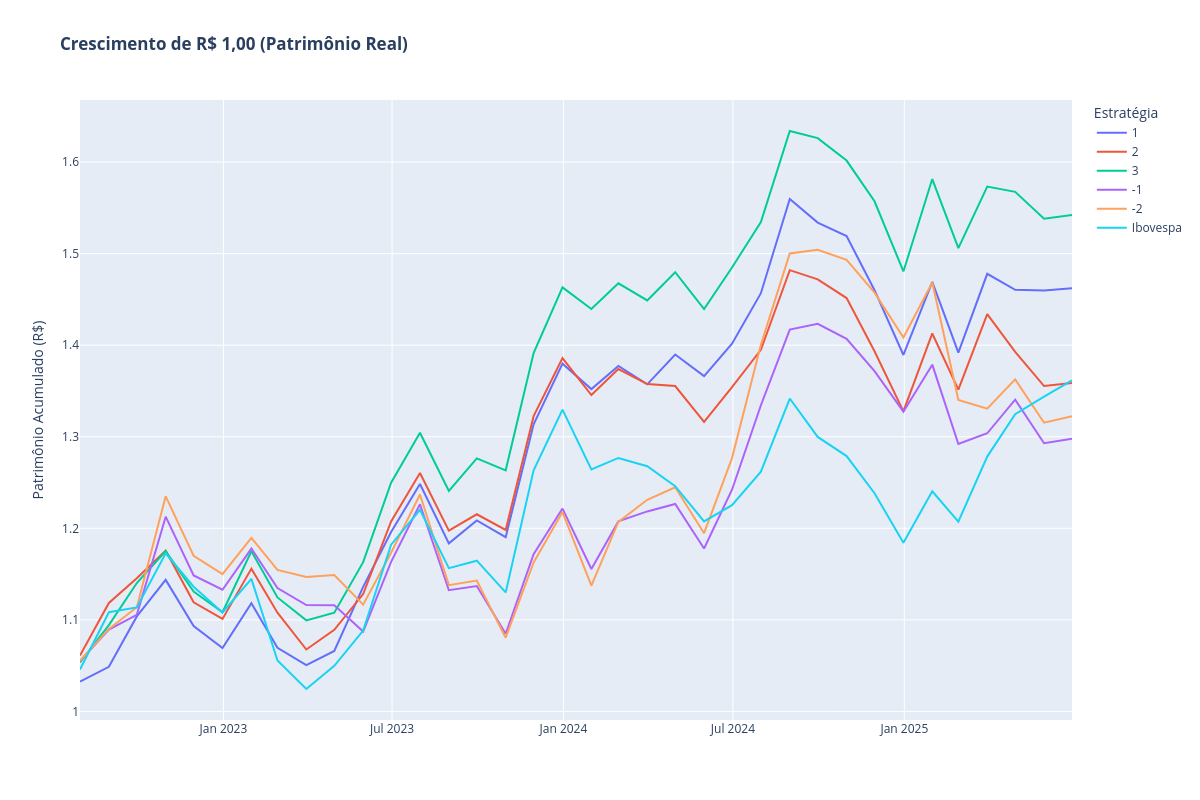

In [31]:
# Supondo que 'df_retornos' (com os retornos excedentes das estratégias),
# 'selic_mensal', 'ibov_retornos_brutos' (brutos) e 'indice_backtest' já existem.

import plotly.io as pio
from IPython.display import Image, display

# Fatia a Selic para o período do backtest
selic_fatiada = selic_mensal.loc[indice_backtest]

# Adiciona a Selic de volta aos retornos excedentes para obter os retornos brutos das estratégias
df_retornos_brutos = df_retornos.add(selic_fatiada['Taxa_Livre_Risco'], axis=0)

# Fatia os retornos brutos do Ibovespa para o mesmo período
ibov_retornos_brutos_fatiado = ibov_retornos_brutos.loc[indice_backtest]


# --- A CORREÇÃO ESTÁ AQUI ---
# Adicionamos a série de retornos do Ibovespa como uma nova coluna
# ao DataFrame que será usado para o gráfico.
df_retornos_brutos['Ibovespa'] = ibov_retornos_brutos_fatiado
# ---------------------------


print("\n--- Gráfico 1: Curva de Patrimônio Real (Baseado nos Retornos Brutos) ---")
df_acumulado_bruto = (1 + df_retornos_brutos).cumprod()

# ✅ Força o índice a ser datetime
df_acumulado_bruto = (1 + df_retornos_brutos).cumprod()

# Converte o índice para datetime (caso ainda não seja)
df_acumulado_bruto.index = pd.to_datetime(df_acumulado_bruto.index)

# Cria lista de datas explícitas
datas = df_acumulado_bruto.index.tolist()

fig_bruto = go.Figure()
for col in df_acumulado_bruto.columns:
    fig_bruto.add_trace(
        go.Scatter(
            x=datas,  # usa lista explícita de datas
            y=df_acumulado_bruto[col],
            mode='lines',
            name=col
        )
    )

fig_bruto.update_layout(
    title_text='<b>Crescimento de R$ 1,00 (Patrimônio Real)</b>',
    yaxis_title='Patrimônio Acumulado (R$)',
    legend_title='Estratégia',
    xaxis=dict(
        tickformat="%b %Y",  # exibe mês abreviado + ano
        tickangle=0
    )
)

# Gráfico interativo
fig_bruto.show()

# Salva o PNG
png_path = "grafico_patrimonio_real.png"
pio.write_image(fig_bruto, png_path, width=1200, height=800)

# Exibe o PNG no notebook
display(Image(filename=png_path))


In [32]:
# --- 1. CÁLCULO DO SHARPE MÓVEL ---

# Define a janela de cálculo. 12 meses (1 ano) é um padrão comum.
janela_movel = 12

# Calcula a média móvel dos retornos
retornos_moveis = df_retornos.rolling(window=janela_movel).mean()

# Calcula o desvio padrão móvel (volatilidade) dos retornos
volatilidade_movel = df_retornos.rolling(window=janela_movel).std()

# Calcula o Sharpe Ratio Móvel e o anualiza para melhor interpretação
# (Multiplicamos pela raiz quadrada de 12 para anualizar)
sharpe_movel_anualizado = (retornos_moveis / volatilidade_movel) * np.sqrt(12)

# Remove os NaNs iniciais (os 11 primeiros meses não têm dados suficientes)
sharpe_movel_anualizado = sharpe_movel_anualizado.dropna()


# --- 2. PLOTAGEM DO GRÁFICO ---

print("\n--- Gráfico de Índice Sharpe Móvel (Janela de 12 Meses) ---")

fig = go.Figure()

# Adiciona uma linha para cada estratégia no DataFrame
for estrategia in sharpe_movel_anualizado.columns:
    fig.add_trace(go.Scatter(
        x=sharpe_movel_anualizado.index,    # Eixo X = Datas
        y=sharpe_movel_anualizado[estrategia], # Eixo Y = Valores do Sharpe
        mode='lines',
        name=estrategia
    ))

# Adiciona uma linha horizontal em y=0 para referência
fig.add_hline(y=0, line_width=1, line_dash="dash", line_color="grey")

fig.update_layout(
    title_text="<b>Índice Sharpe Móvel Anualizado (Janela de 12 Meses)</b>",
    yaxis_title="Índice Sharpe Anualizado",
    xaxis_title="Data",
    legend_title="Estratégia"
)

fig.show()


--- Gráfico de Índice Sharpe Móvel (Janela de 12 Meses) ---


In [33]:
pip install statsmodels


Note: you may need to restart the kernel to use updated packages.


In [35]:
import statsmodels.api as sm

# Supondo que 'resultados_backtest' e 'ibov_retornos_excedentes' já existem
# e que 'metodos_a_testar' é o dicionário com os nomes das estratégias

# É melhor iterar pelas chaves do dicionário de resultados,
# para garantir que só analisamos as estratégias que rodaram com sucesso.
for i in resultados_backtest.keys():
    print(f"\n--- Análise de Regressão para a Estratégia: {metodos_a_testar.get(i, i)} ---")
    
    y = resultados_backtest[i]
    
    # --- A CORREÇÃO ESTÁ AQUI ---
    # Alinhamos o X (Ibovespa) para ter exatamente o mesmo índice (datas) que o y (estratégia)
    X = ibov_retornos_excedentes.loc[y.index]
    # ---------------------------

    # Adiciona a constante (para o alfa) ao X já alinhado
    X = sm.add_constant(X)
    
    # Agora a regressão funcionará, pois os índices de y e X são idênticos
    modelo = sm.OLS(y, X).fit()

    print(modelo.summary()) # Exibe a tabela completa da regressão

    # Extrai os parâmetros
    alfa_mensal = modelo.params['const']
    beta = modelo.params.get(X.columns[1], modelo.params.iloc[1])
    
    print(f"\nAlfa Mensal (habilidade do gestor): {alfa_mensal*100:.4f}%")
    print(f"Beta (exposição ao mercado): {beta:.4f}")
    
    # Interpretação do Alfa
    p_valor_alfa = modelo.pvalues['const']
    if p_valor_alfa < 0.05:
        print("-> O Alfa é estatisticamente significante (p < 0.05), indicando que a estratégia gerou um retorno que não é explicado pelo mercado. ✅")
    else:
        print("-> O Alfa não é estatisticamente significante (p >= 0.05), indicando que o desempenho pode ser atribuído ao acaso. ❌")


--- Análise de Regressão para a Estratégia: BL com RF ---
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     109.0
Date:                Sat, 04 Oct 2025   Prob (F-statistic):           3.84e-12
Time:                        15:53:12   Log-Likelihood:                 90.972
No. Observations:                  36   AIC:                            -177.9
Df Residuals:                      34   BIC:                            -174.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------